In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [38]:
# Reading the data
df = pd.read_csv("/content/spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [39]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


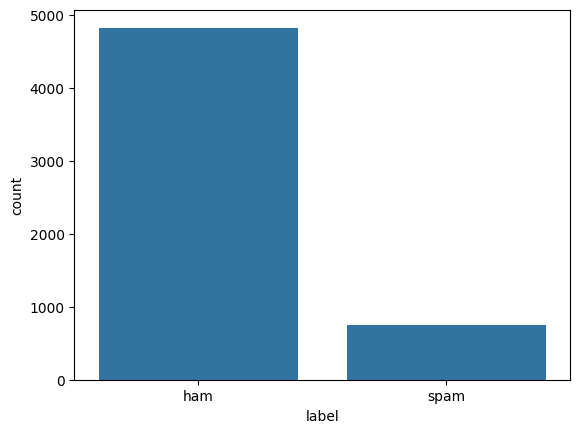

In [40]:
sns.countplot(x=df['label'])
plt.show()

In [41]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

16


In [42]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15686


In [43]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

**Building the models**

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

**Model -2 Bidirectional LSTM**

A bidirectional LSTM (Long short-term memory) is made up of two LSTMs, one accepting input in one direction and the other in the other. BiLSTMs effectively improve the network's accessible information, boosting the context for the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence).

In [59]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
	64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test) # fit the model

# This code is modified by Susobhan Akhuli

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - accuracy: 0.9003 - loss: 0.2826 - val_accuracy: 0.9722 - val_loss: 0.0865
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.9917 - loss: 0.0371 - val_accuracy: 0.9803 - val_loss: 0.0783
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9953 - loss: 0.0202 - val_accuracy: 0.9668 - val_loss: 0.1024
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9990 - loss: 0.0049 - val_accuracy: 0.9803 - val_loss: 0.1005
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9997 - loss: 0.0023 - val_accuracy: 0.9839 - val_loss: 0.0990


In [62]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Disable XLA compilation
tf.config.optimizer.set_jit(False)

# model with functional api
input_layer = keras.Input(shape=[], dtype=tf.string)

# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2?tfhub-redirect=true",
						trainable=False,
						input_shape=[],
						dtype=tf.string,
						name='USE')

# Create a Lambda layer to wrap the use_layer call
# Specify the output shape of the USE layer
x = layers.Lambda(lambda x: use_layer(x), output_shape=(512,))(input_layer)

x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation=keras.activations.relu)(x)
output_layer = layers.Dense(1, activation=keras.activations.sigmoid)(x)

model_3 = keras.Model(input_layer, output_layer)

compile_model(model_3)


history_3 = fit_model(model_3, epochs=5)



Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8771 - loss: 0.4275 - val_accuracy: 0.9731 - val_loss: 0.1083
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9770 - loss: 0.0884 - val_accuracy: 0.9776 - val_loss: 0.0683
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9800 - loss: 0.0649 - val_accuracy: 0.9821 - val_loss: 0.0582
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9865 - loss: 0.0522 - val_accuracy: 0.9857 - val_loss: 0.0548
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9875 - loss: 0.0421 - val_accuracy: 0.9839 - val_loss: 0.0517


In [71]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
# Assuming model_1 and its related components (text_vec, embedding_layer) are defined elsewhere
# If model_1 is a Keras model, it would also need X_test to be converted to numpy array
# For now, I'm commenting out model_1 as it's not fully defined in the provided notebook state
# model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                             'Bidirectional-LSTM Model':model_2_results,
                             'USE-Transfer learning Model':model_3_results}).transpose()

total_results

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.963229,1.000000,0.724832,0.840467
Bidirectional-LSTM Model,0.983857,0.971223,0.906040,0.937500
USE-Transfer learning Model,0.983857,0.951724,0.926174,0.938776


In [72]:
total_results

,accuracy,precision,recall,f1-score
MultinomialNB Model,0.963229,1.000000,0.724832,0.840467
Bidirectional-LSTM Model,0.983857,0.971223,0.906040,0.937500
USE-Transfer learning Model,0.983857,0.951724,0.926174,0.938776


from matplotlib import pyplot as plt
total_results['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
total_results['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
total_results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
total_results['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
total_results.plot(kind='scatter', x='accuracy', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
total_results.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
total_results.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['accuracy']
  ys = series['precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = total_results.sort_values('accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'accuracy'}, axis=1)
              .sort_values('accuracy', ascending=True))
  xs = counted['accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = total_results.sort_values('accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['recall']
  ys = series['precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = total_results.sort_values('recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('recall')
_ = plt.ylabel('precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['recall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'recall'}, axis=1)
              .sort_values('recall', ascending=True))
  xs = counted['recall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = total_results.sort_values('recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('recall')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
total_results['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
total_results['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
total_results['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
total_results['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)